Copyright 2022 Google LLC

Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file except in compliance with the License. You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.


# Unified Functional Hashing
This colab accompanies the paper "Gillard et al 2022... Unified Functional Hashing" {link} and the rest of the code at https://github.com/google-research/unified_functional_hashing.

In this colab, we demonstrate simple usage of the Functional Equivalence Cache presented in the paper on the NASBench-101 dataset {link}. Please see paper for evaluation of the method and baselines on more complex datasets at scale.

If you find this code or paper useful, please cite:

```
@article{uid,
title = {Unified Functional Hashing for Automatic Machine Learning},
author = {Ryan Gillard and Stephen Jonany and Yingjie Miao and Michael Munn and Connal de Souza and Jonathan Dungay and Chen Liang and David R. So and Quoc V. Le and Esteban Real},
journal = {-}
}
```

## Imports

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import sys
import tensorflow as tf
tf.python_io = tf.compat.v1.io  # Alias for NASBench-101 compatibility




### Local Imports
We need to import the unified functional hashing src files. Please update the directory below appropriately to point to the src files. Alternatively, the src files can be downloaded.

In [ ]:
SRC_DIRECTORY = %pwd +'/nasbench/python' # please update
DOWNLOAD_SRC = True
try:
  if DOWNLOAD_SRC:
    !git clone https://github.com/google-research/unified_functional_hashing
    !pip install ./unified_functional_hashing
    SRC_DIRECTORY = %pwd +'/nasbench/python'
    DOWNLOAD_SRC = False

  module_path = os.path.abspath(os.path.join('..'))
  if module_path not in sys.path:
    sys.path.append(module_path)   
  if SRC_DIRECTORY not in sys.path:
    sys.path.append(SRC_DIRECTORY)
    
  from unified_functional_hashing.nasbench.python import run_worker_util
except Exception as e:
  print(repr(e))
  print("Please set SET_DIRECTORY and DOWNLOAD_SRC appropriately to enable finding the src files")



### Load NASBench library and dataset

In [41]:
# Download the raw data.
!curl -O https://storage.googleapis.com/nasbench/nasbench_full.tfrecord

# Initialize the NASBench object which parses the raw data into memory (this
# should only be run once as it takes up to a few minutes).
from nasbench import api

# Use nasbench_full.tfrecord for full dataset (run download command above).
nasbench = api.NASBench('nasbench_full.tfrecord')


Loading dataset from file... This may take a few minutes...
Loaded dataset in 253 seconds


## Helper Functions
Define a function for plotting the metadata produced by running an experiment.



In [ ]:

import numpy as np

def plot_data_summary(experiment_metadata, color, label, plot_meta_training=False, gran=10000, max_budget=5000000):
  """Computes the mean and IQR fitness of a set of repeats at fixed time steps and plots
  them.

  Args:
    experiment_metadata: Object containing metadata from a full experiment (set of repeats).
    color: Color of line to use for plotting this experiment's results
    label: Label to use in the legend for plotting this experiment's results
    plot_meta_training: If true, plot the metatraining fitnesses. Otherwise, plot the metavalidation fitnesses.
    gran: Granularity of plot points. One point will be plotted for every gran time steps
    max_budget: The limit of how far to plot the data in time steps.
  
  """

  xs = range(0, max_budget + 1, gran)
  mean = [0.0]
  minus = [0.0]
  plus = [0.0]
  
  repeats = len(experiment_metadata.repeat_metadata)
  pointers = [1 for _ in range(repeats)]
  
  cur = gran
  while cur < max_budget + 1:
    all_vals = []
    for repeat in range(repeats):
      while (pointers[repeat] < len(experiment_metadata.repeat_metadata[repeat].times) and 
             experiment_metadata.repeat_metadata[repeat].times[pointers[repeat]] < cur):
        pointers[repeat] += 1
      prev_time = experiment_metadata.repeat_metadata[repeat].times[pointers[repeat]-1]
      if plot_meta_training:
        prev_fitness = experiment_metadata.repeat_metadata[repeat].best_valids[pointers[repeat]-1]
      else:
        prev_fitness = experiment_metadata.repeat_metadata[repeat].best_tests[pointers[repeat]-1]

      next_time = experiment_metadata.repeat_metadata[repeat].times[pointers[repeat]]
      if plot_meta_training:
        next_fitness = experiment_metadata.repeat_metadata[repeat].best_valids[pointers[repeat]]
      else:
        next_fitness = experiment_metadata.repeat_metadata[repeat].best_tests[pointers[repeat]]

      assert prev_time < cur and next_time >= cur

      # Linearly interpolate the test between the two surrounding points
      cur_val = ((cur - prev_time) / (next_fitness - prev_time)) * (next_fitness - prev_fitness) + prev_fitness
      
      all_vals.append(cur_val)
    all_vals_arr = np.array(all_vals)
    mu = np.mean(all_vals_arr)
    mean.append(mu)
    stddev = np.std(all_vals_arr)
    sem = stddev / np.sqrt(len(all_vals_arr))
    minus.append(mu - 2 * sem)
    plus.append(mu + 2 * sem)
      
    cur += gran
  if plot_meta_training:
    y_label = "Validation Accuracy"
  else:
    y_label = "Test Accuracy"
      
  plt.ylim(0.92, 0.96)
  plt.xlabel('Total training time (s)')
  plt.ylabel(y_label)
  plt.grid()
  plt.plot(xs, mean, color=color, label=label, linewidth=2)
  plt.legend(loc='lower right')
  plt.fill_between(xs, minus, plus, alpha=0.1, linewidth=0, facecolor=color)

def plot_data_raw(experiment_metadata, color, label, plot_meta_training=False, gran=10000, max_budget=5000000):
  for repeat_metadata in experiment_metadata.repeat_metadata:
    if plot_meta_training:
      yvalues = repeat_metadata.best_valids
    else:
      yvalues = repeat_metadata.best_tests
    plt.plot(repeat_metadata.times, yvalues, c=color, linestyle="solid", alpha=1)
  if plot_meta_training:
    y_label = "Validation Accuracy"
  else:
    y_label = "Test Accuracy"
      
  plt.ylim(0.92, 0.96)
  plt.xlabel('Total training time (s)')
  plt.ylabel(y_label)
  plt.grid()
  plt.legend(loc='lower right')

## Run Experiments
The first being a baseline - NASBench 101 with Regularized evolution, and the second being the same but with the addition of the Functional Equivalence Cache (FEC).

In [52]:
# Search parameters
EXPERIMENT_REPEATS = 5
MUTATION_RATE = 1.0
POPULATION_SIZE = 100
TOURNAMENT_SIZE = 10
SEARCH_METHOD = "regularized_evolution"
MAX_TIME_BUDGET = 5e6
MAX_NUM_EVALS = 1

RNG_SEED=None

# Evaluation parameters
NOISE_TYPE = ""
NOISE_STDDEV = 0
# Note that this needs to be set to 0,1, or 2 for deterministic evaluations and unaltered evolutionary dynamics from FEC.
FIXED_RUN_IDX = -1

repeat_indices = ",".join([str(i) for i in range(EXPERIMENT_REPEATS)])

base_experiment_metadata = run_worker_util.run_experiment(
      nasbench=nasbench,
      experiment_repeat_indices=repeat_indices,
      fec_remove_probability=0.0,
      fixed_run_idx=FIXED_RUN_IDX,
      hashing_time=0,
      mantissa_bits=0,
      max_num_evals=MAX_NUM_EVALS,
      max_time_budget=MAX_TIME_BUDGET,
      mutation_rate=MUTATION_RATE,
      noise_type=NOISE_TYPE,
      noise_stddev=NOISE_STDDEV,
      population_size=POPULATION_SIZE,
      save_child_history=True,
      save_fec_history=True,
      search_method=SEARCH_METHOD,
      tournament_size=TOURNAMENT_SIZE,
      use_fec=False,
      rng_seed=RNG_SEED
  )

# FEC specific parameters
HASHING_TIME = 10
MANTISSA_BITS = 24
FEC_REMOVE_PROBABILITY = 0.0


fec_experiment_metadata = run_worker_util.run_experiment(
      nasbench=nasbench,
      experiment_repeat_indices=repeat_indices,
      fec_remove_probability=FEC_REMOVE_PROBABILITY,
      fixed_run_idx=FIXED_RUN_IDX,
      hashing_time=HASHING_TIME,
      mantissa_bits=MANTISSA_BITS,
      max_num_evals=MAX_NUM_EVALS,
      max_time_budget=MAX_TIME_BUDGET,
      mutation_rate=MUTATION_RATE,
      noise_type=NOISE_TYPE,
      noise_stddev=NOISE_STDDEV,
      population_size=POPULATION_SIZE,
      save_child_history=True,
      save_fec_history=True,
      search_method=SEARCH_METHOD,
      tournament_size=TOURNAMENT_SIZE,
      use_fec=True,
      rng_seed=RNG_SEED
  )

Starting NASBench experiment repeat 0...
iterations = 0, time_spent = 110475.81756591797, best_valid = 0.9420071840286255
iterations = 100, time_spent = 288924.4511413574, best_valid = 0.9472155570983887
iterations = 200, time_spent = 454369.0227050781, best_valid = 0.9472155570983887
iterations = 300, time_spent = 627174.5986633301, best_valid = 0.9481169581413269
iterations = 400, time_spent = 793445.546661377, best_valid = 0.9481169581413269
iterations = 500, time_spent = 964071.4317321777, best_valid = 0.9481169581413269
iterations = 600, time_spent = 1133795.5177612305, best_valid = 0.9481169581413269
iterations = 700, time_spent = 1303277.0579223633, best_valid = 0.9481169581413269
iterations = 800, time_spent = 1480488.333404541, best_valid = 0.9481169581413269
iterations = 900, time_spent = 1651713.6498413086, best_valid = 0.9481169581413269
iterations = 1000, time_spent = 1826743.158050537, best_valid = 0.9481169581413269
iterations = 1100, time_spent = 1990991.6941833496, bes

## Plot Results
We plot the results of both experiments.


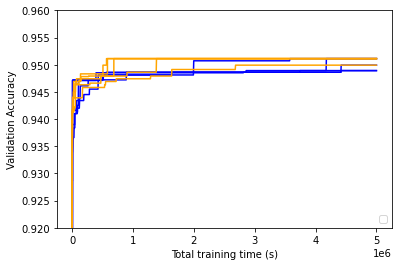

In [54]:
plt.figure()
plot_data_raw(base_experiment_metadata, 'blue', 'baseline', plot_meta_training=True)
plot_data_raw(fec_experiment_metadata, 'orange', 'fec', plot_meta_training=True)


